# Chronic Kidney Disease Prediction

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.Max_columns', None)

In [2]:
# Loading the dataset
data = pd.read_csv('kidney_disease.csv')

In [3]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
data.shape

(400, 26)

In [5]:
round(100*data.isnull().sum()/data.shape[0], 2)

id                 0.00
age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.50
wc                26.25
rc                32.50
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

In [6]:
data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

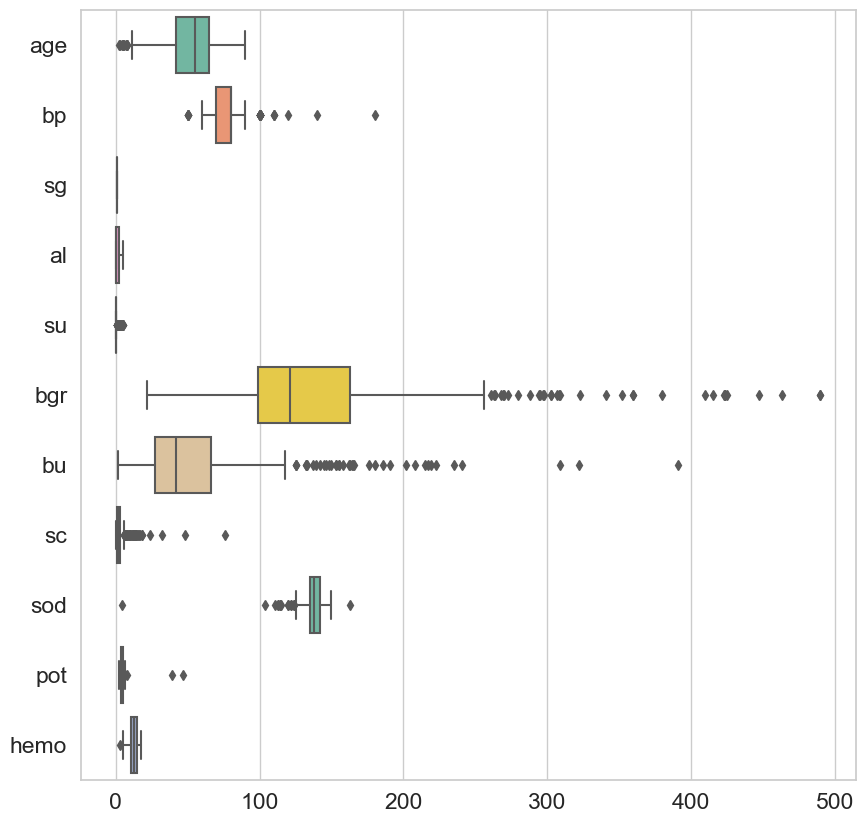

In [7]:
# Visualizing the data using Box Plots
num_cols = list(data.select_dtypes(exclude = 'object').columns[1:])
plt.figure(figsize=(10, 10))
sns.set(style='whitegrid', font_scale=1.5)
sns.boxplot(data=data[num_cols], orient='h', palette='Set2')
plt.show()

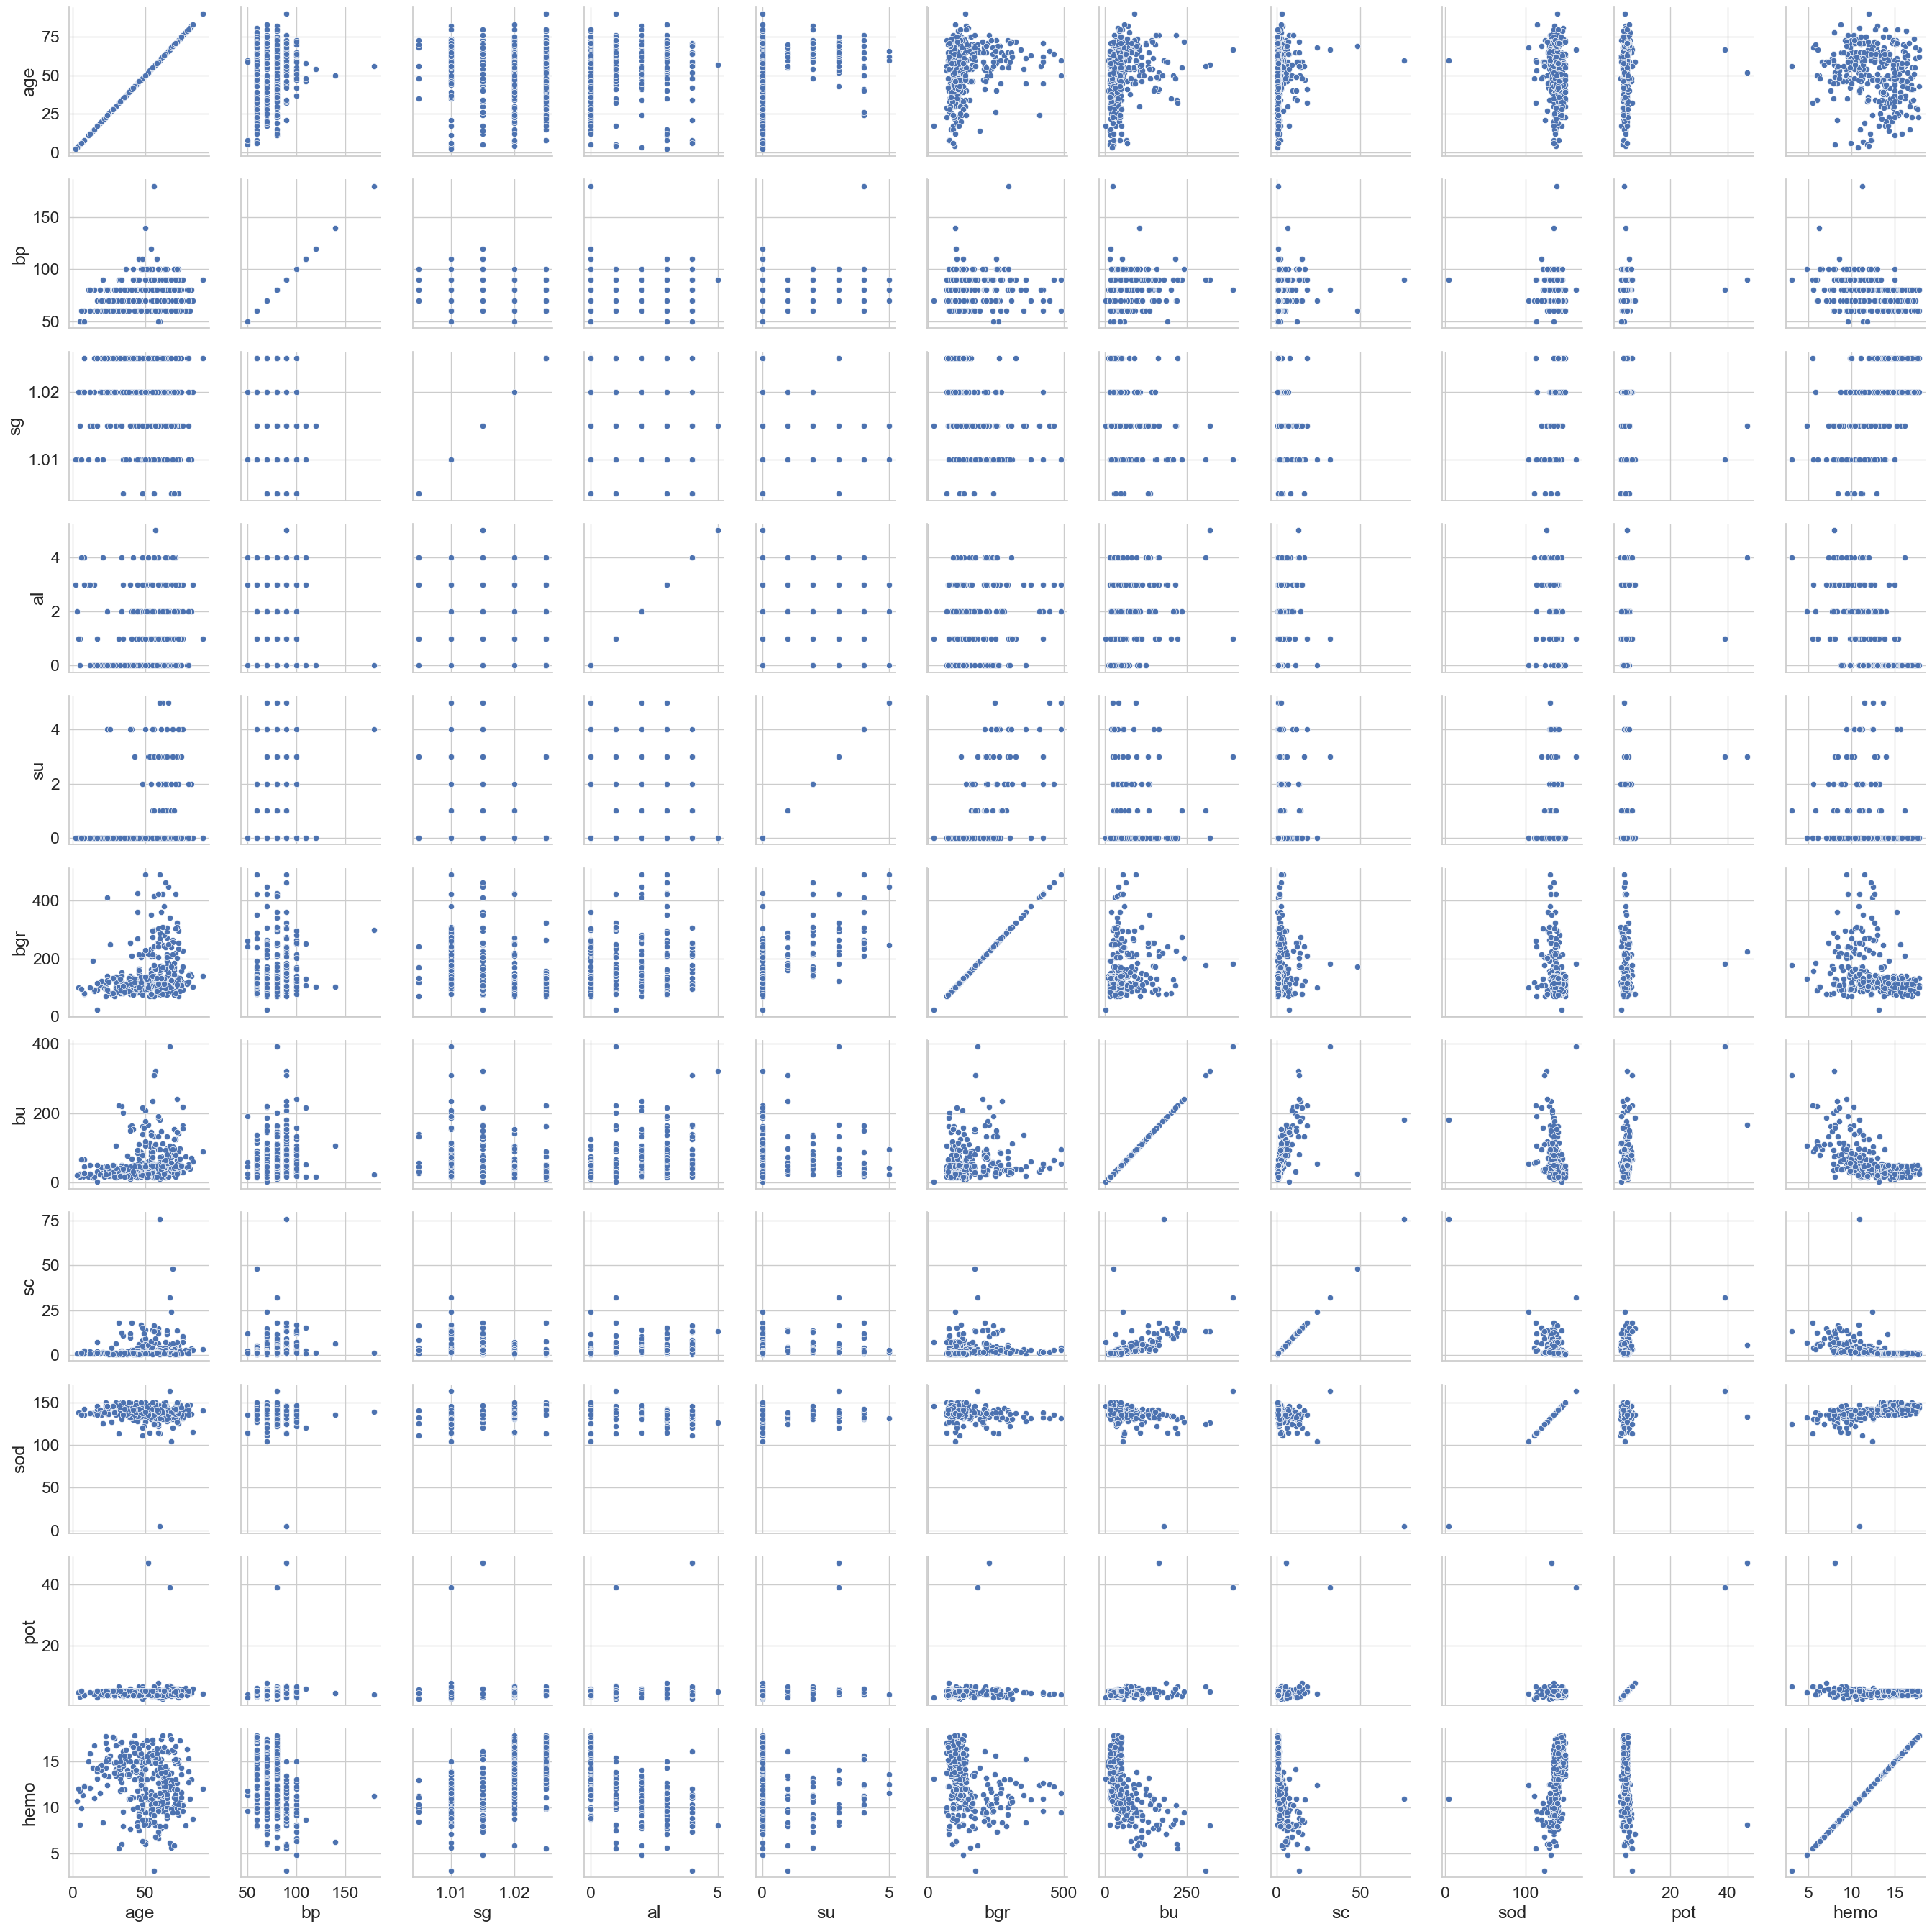

In [8]:
g = sns.PairGrid(data[num_cols])
g.map(sns.scatterplot)
plt.show()

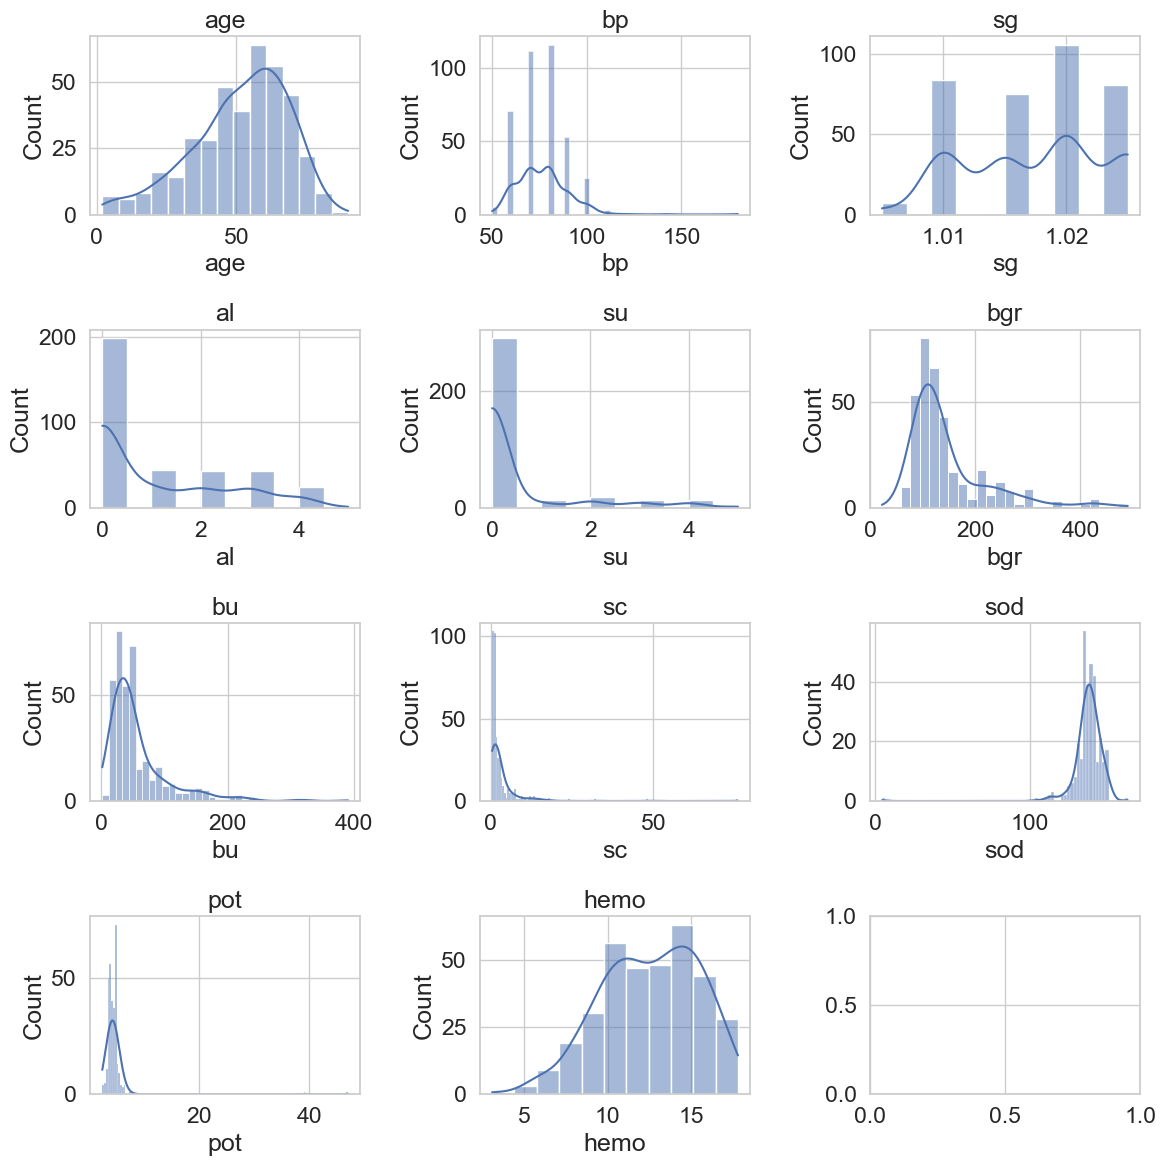

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [10]:
# Imputing the values with Median
for col in num_cols:
    value = data[col].median()
    data[col].fillna(value, inplace = True)

In [11]:
categorical_cols = list(data.select_dtypes(include='object').columns)

In [12]:
data['classification'].value_counts()

ckd       248
notckd    150
ckd\t       2
Name: classification, dtype: int64

In [13]:
data = data[data['classification'] != 'ckd\t']

In [14]:
for col in categorical_cols:
    print(data[col].mode()[0])

normal
normal
notpresent
notpresent
41
9800
5.2
no
no
no
good
no
no
ckd


In [15]:
# These are also numerical columns but appearing as object columns.
data[['pcv', 'wc', 'rc']].head()

,pcv,wc,rc
0,44,7800,5.2
1,38,6000,NaN
2,31,7500,NaN
3,32,6700,3.9
4,35,7300,4.6


In [16]:
# Detecting non-numeric values in the 'pcv' column
non_numeric_values = data.loc[~data['pcv'].astype(str).str.match(r'^-?\d+\.?\d*$')]['pcv'].unique()
non_numeric_values

array([nan, '\t?', '\t43'], dtype=object)

In [17]:
# Replace '\t?' and '\t43' with NaN
data['pcv'] = data['pcv'].replace(['\t?', '\t43'], np.nan)

In [18]:
# Detecting non-numeric values in the 'wc' column
non_numeric_values = data.loc[~data['wc'].astype(str).str.match(r'^-?\d+\.?\d*$')]['wc'].unique()
non_numeric_values

array([nan, '\t6200', '\t8400', '\t?'], dtype=object)

In [19]:
# Replace these values with NaN
data['wc'] = data['wc'].replace(['\t6200', '\t8400', '\t?'], np.nan)

In [20]:
# Detecting non-numeric values in the 'rc' column
non_numeric_values = data.loc[~data['rc'].astype(str).str.match(r'^-?\d+\.?\d*$')]['rc'].unique()
non_numeric_values

array([nan, '\t?'], dtype=object)

In [21]:
# Replace the value with NaN
data['rc'] = data['rc'].replace(['\t?'], np.nan)

In [22]:
# Colverting these columns into float
data['pcv'] = data['pcv'].astype(float)
data['wc'] = data['wc'].astype(float)
data['rc'] = data['rc'].astype(float)

In [23]:
# Imputing the values with Median
for col in ['pcv', 'wc', 'rc']:
    value = data[col].median()
    data[col].fillna(value, inplace = True)

In [24]:
categorical_cols = list(data.select_dtypes(include='object').columns)

In [25]:
categorical_cols

['rbc',
 'pc',
 'pcc',
 'ba',
 'htn',
 'dm',
 'cad',
 'appet',
 'pe',
 'ane',
 'classification']

In [26]:
categorical_cols = list(data[categorical_cols].columns[:-1])

In [27]:
100*data[categorical_cols].isnull().sum()/data.shape[0]

rbc      37.939698
pc       16.080402
pcc       1.005025
ba        1.005025
htn       0.502513
dm        0.502513
cad       0.502513
appet     0.251256
pe        0.251256
ane       0.251256
dtype: float64

In [28]:
data['rbc'].fillna(data['rbc'].mode()[0], inplace = True)
data['pc'].fillna(data['pc'].mode()[0], inplace = True)
data['pcc'].fillna(data['pcc'].mode()[0], inplace = True)
data['ba'].fillna(data['ba'].mode()[0], inplace = True)
data['htn'].fillna(data['htn'].mode()[0], inplace = True)
data['dm'].fillna(data['dm'].mode()[0], inplace = True)
data['cad'].fillna(data['cad'].mode()[0], inplace = True)
data['appet'].fillna(data['appet'].mode()[0], inplace = True)
data['pe'].fillna(data['pe'].mode()[0], inplace = True)
data['ane'].fillna(data['ane'].mode()[0], inplace = True)

In [29]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [30]:
for col in categorical_cols:
    print(col, ':', list(data[col].value_counts().index))
    print('==============================================')

rbc : ['normal', 'abnormal']
pc : ['normal', 'abnormal']
pcc : ['notpresent', 'present']
ba : ['notpresent', 'present']
htn : ['no', 'yes']
dm : ['no', 'yes', '\tno', '\tyes', ' yes']
cad : ['no', 'yes', '\tno']
appet : ['good', 'poor']
pe : ['no', 'yes']
ane : ['no', 'yes']


In [31]:
# Correcting the errors
data['dm'] = data['dm'].replace('\tno', 'no')
data['dm'] = data['dm'].replace('\tyes', 'yes')
data['dm'] = data['dm'].replace(' yes', 'yes')

In [32]:
data['cad'] = data['cad'].replace('\tno', 'no')

In [33]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [34]:
for col in categorical_cols:
    print(col, ':', list(data[col].value_counts().index))
    print('==============================================')

rbc : ['normal', 'abnormal']
pc : ['normal', 'abnormal']
pcc : ['notpresent', 'present']
ba : ['notpresent', 'present']
htn : ['no', 'yes']
dm : ['no', 'yes']
cad : ['no', 'yes']
appet : ['good', 'poor']
pe : ['no', 'yes']
ane : ['no', 'yes']


In [35]:
# Using one-hot encoding

for col in categorical_cols:
    values = list(data[col].value_counts().index)
    data[col] = data[col].map({values[0]:0, values[1]:1})

In [36]:
data['classification'] = data['classification'].map({'ckd':1, 'notckd':0})

In [37]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2,1,1,0,0,0,0,1
1,1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0,0,0,0,0,0,1
2,2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8,0,1,0,1,0,1,1
3,3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,1,0,0,1,1,1,1
4,4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6,0,0,0,0,0,0,1


In [38]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['id', 'classification'], axis = 1), data['classification'],
                                                    random_state=0, test_size=0.3, stratify=data['classification'])

In [39]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [40]:
# Model Building

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# Create a random forest classifier object
rf = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=2)

In [41]:
# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [42]:
rfc_final = RandomForestClassifier(**grid_search.best_params_)

In [43]:
rfc_final.fit(X_train, y_train)
train_predictions = rfc_final.predict(X_train)
test_predictions = rfc_final.predict(X_test)

In [44]:
print('F1 score on Train set:', f1_score(y_train, train_predictions))
print('F1 score on Test set:', f1_score(y_test, test_predictions))

F1 score on Train set: 1.0
F1 score on Test set: 0.9866666666666668


In [45]:
# Checking for overlap
len1 = pd.concat([X_train, X_test]).shape[0]
len2 = pd.concat([X_train, X_test]).drop_duplicates().shape[0]

if len1 == len2:
    print('No Overlap')
else:
    print('Overlap')

No Overlap


In [47]:
imp = pd.DataFrame(list(zip(rfc_final.feature_names_in_, rfc_final.feature_importances_)), 
                   columns=['Feature', 'Coeff'])
imp = imp.sort_values(by = 'Coeff', ascending = False)

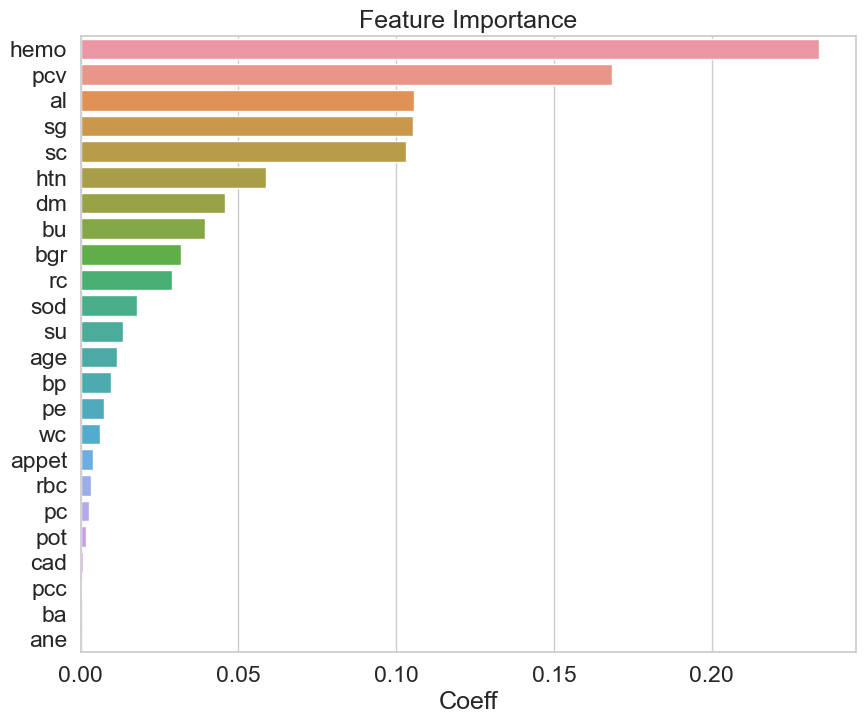

In [56]:
plt.figure(figsize=(10, 8))
sns.barplot(y = imp['Feature'], x = imp['Coeff'])
plt.title('Feature Importance')
plt.ylabel('')
plt.show()